In [1]:
import torch
print(torch.cuda.is_available())        
print(torch.cuda.get_device_name(0))    

True
NVIDIA GeForce RTX 2060


In [5]:
import os
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import DataLoader, Dataset
from PIL import Image
from sklearn.preprocessing import LabelEncoder

class FER2013Dataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.samples = []

        for emotion_dir in sorted(os.listdir(root_dir)):
            emotion_path = os.path.join(root_dir, emotion_dir)
            if not os.path.isdir(emotion_path):
                continue
            for img_name in os.listdir(emotion_path):
                img_path = os.path.join(emotion_path, img_name)
                self.samples.append((img_path, emotion_dir))

        self.le = LabelEncoder()
        self.labels = self.le.fit_transform([label for _, label in self.samples])

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert("L")  # Grayscale
        if self.transform:
            image = self.transform(image)
        label = self.le.transform([label])[0]
        return image, label

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

train_dir = os.path.expanduser("~/.cache/kagglehub/datasets/msambare/fer2013/versions/1/train")
test_dir = os.path.expanduser("~/.cache/kagglehub/datasets/msambare/fer2013/versions/1/test")

train_dataset = FER2013Dataset(train_dir, transform=transform)
test_dataset = FER2013Dataset(test_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet50(pretrained=True)
model.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
model.fc = nn.Linear(model.fc.in_features, 7)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)


def train_model(num_epochs=30):
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        correct, total = 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            del images, labels, outputs, loss
            torch.cuda.empty_cache()

        scheduler.step()
        train_acc = 100 * correct / total
        print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {total_loss:.4f} - Train Accuracy: {train_acc:.2f}%")

        

def evaluate_model():
    model.eval()
    correct, total = 0, 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")
    torch.save(model.state_dict(), "resnet50_fer2013_last.pth")
    print(" Model saved as 'resnet50_fer2013_last.pth'")



if __name__ == "__main__":
    print("Starting training on FER2013 with ResNet50...")
    # train_model(num_epochs=30)
    # evaluate_model()



/home/turtle/anaconda3/envs/project-oval/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/turtle/anaconda3/envs/project-oval/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Starting training on FER2013 with ResNet50...


Evaluating model performance...


/tmp/ipykernel_4888/2011630954.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("resnet34_fer2013_error68.pth"))


Test Accuracy: 68.72%


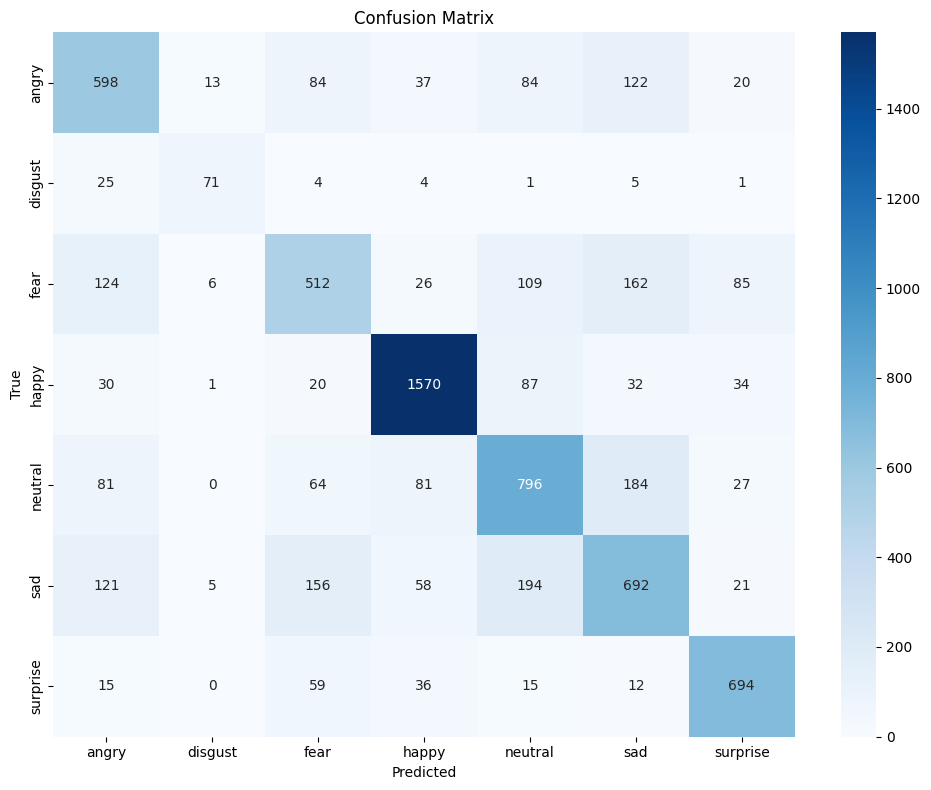

Classification Report:
              precision    recall  f1-score   support

       angry       0.60      0.62      0.61       958
     disgust       0.74      0.64      0.69       111
        fear       0.57      0.50      0.53      1024
       happy       0.87      0.89      0.88      1774
     neutral       0.62      0.65      0.63      1233
         sad       0.57      0.55      0.56      1247
    surprise       0.79      0.84      0.81       831

    accuracy                           0.69      7178
   macro avg       0.68      0.67      0.67      7178
weighted avg       0.68      0.69      0.69      7178



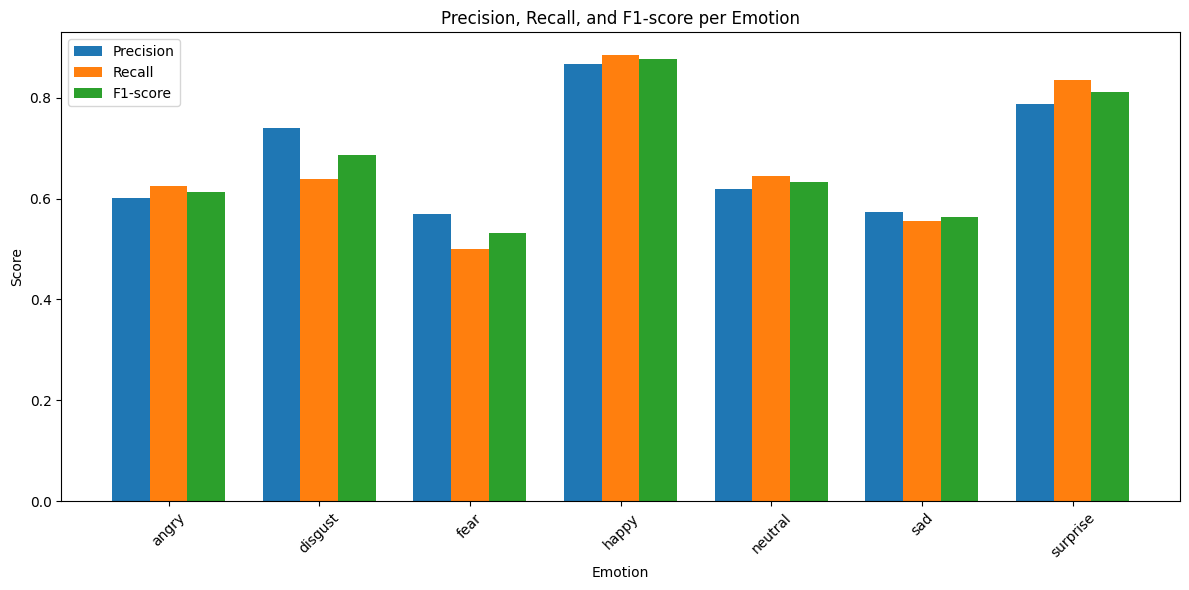

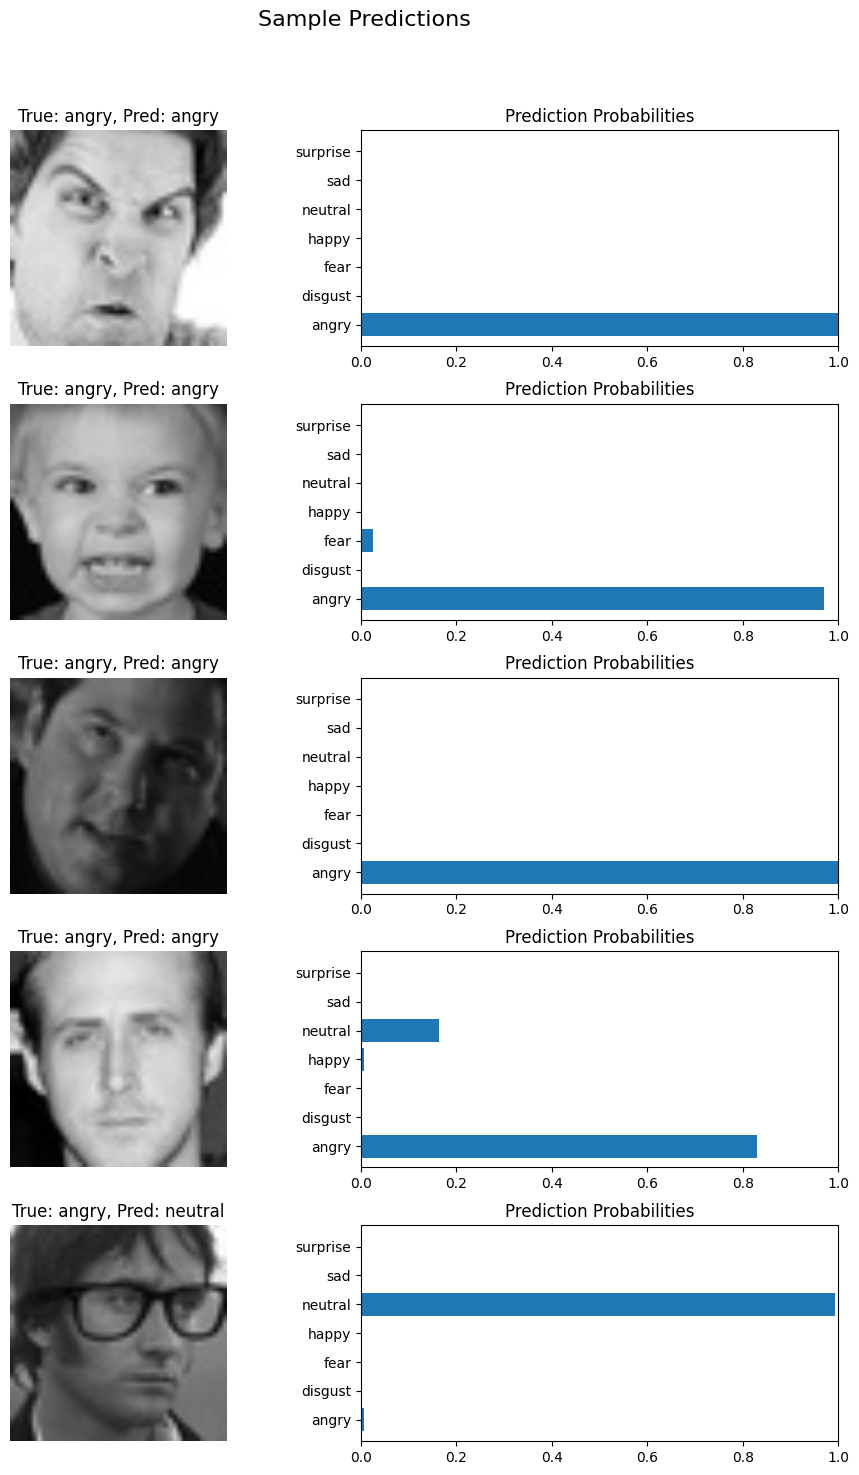

In [6]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_recall_fscore_support
import torchvision.models as models

def load_model_and_evaluate():
    
    model = models.resnet34(weights=None)
    model.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
    model.fc = nn.Linear(model.fc.in_features, 7)
    
    
    model.load_state_dict(torch.load("resnet34_fer2013_error68.pth"))
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    
    all_predictions = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    
    accuracy = accuracy_score(all_labels, all_predictions)
    print(f"Test Accuracy: {accuracy*100:.2f}%")
    
    
    emotion_labels = test_dataset.le.classes_
    
    
    cm = confusion_matrix(all_labels, all_predictions)
    
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=emotion_labels, 
                yticklabels=emotion_labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.savefig('resnet_confusion_matrix.png')
    plt.show()
    
    
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_predictions, average=None)
    
    
    print("Classification Report:")
    print(classification_report(all_labels, all_predictions, target_names=emotion_labels))
    
    
    plt.figure(figsize=(12, 6))
    x = np.arange(len(emotion_labels))
    width = 0.25
    
    plt.bar(x - width, precision, width, label='Precision')
    plt.bar(x, recall, width, label='Recall')
    plt.bar(x + width, f1, width, label='F1-score')
    
    plt.xlabel('Emotion')
    plt.ylabel('Score')
    plt.title('Precision, Recall, and F1-score per Emotion')
    plt.xticks(x, emotion_labels, rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.savefig('resnet_per_class_metrics.png')
    plt.show()
    
    def visualize_predictions(num_samples=5):
        fig, axes = plt.subplots(num_samples, 2, figsize=(10, 3*num_samples))
        fig.suptitle('Sample Predictions', fontsize=16)
        
        with torch.no_grad():
            for i, (images, labels) in enumerate(test_loader):
                if i >= num_samples:
                    break
                    
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                
                
                img = images[0].cpu().permute(1, 2, 0).numpy()
                
                img = (img * 0.5 + 0.5).clip(0, 1)
                true_label = emotion_labels[labels[0].item()]
                pred_label = emotion_labels[predicted[0].item()]
                
                
                probs = torch.nn.functional.softmax(outputs[0], dim=0).cpu().numpy()
                
                # Plot image
                axes[i, 0].imshow(img)
                axes[i, 0].set_title(f'True: {true_label}, Pred: {pred_label}')
                axes[i, 0].axis('off')
                
                
                axes[i, 1].barh(emotion_labels, probs)
                axes[i, 1].set_xlim(0, 1)
                axes[i, 1].set_title('Prediction Probabilities')
                
        plt.tight_layout()
        plt.subplots_adjust(top=0.9)
        plt.savefig('resnet_sample_predictions.png')
        plt.show()
    
    visualize_predictions()
    
    return accuracy, precision, recall, f1

if __name__ == "__main__":
    print("Evaluating model performance...")
    accuracy, precision, recall, f1 = load_model_and_evaluate()